In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from model_day import get_data

raw_data, df_final, final_date = get_data()

data = load_dataset("boomsss/spx_intra", split='train')

rows = [d['text'] for d in data]
rows = [x.split(',') for x in rows]

fr = pd.DataFrame(columns=[
    'Datetime','Open','High','Low','Close'
], data = rows)

fr['Datetime'] = pd.to_datetime(fr['Datetime'])
fr['Datetime'] = fr['Datetime'].dt.tz_localize('America/New_York')
fr = fr.set_index('Datetime')
fr['Open'] = pd.to_numeric(fr['Open'])
fr['High'] = pd.to_numeric(fr['High'])
fr['Low'] = pd.to_numeric(fr['Low'])
fr['Close'] = pd.to_numeric(fr['Close'])

Found cached dataset text (C:/Users/WINSTON-ITX/.cache/huggingface/datasets/boomsss___text/boomsss--SPX_full_30min-37ae67efd8a1cc91/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)
Merging econ data: 100%|██████████| 8/8 [00:00<00:00, 1141.77it/s]
Found cached dataset text (C:/Users/WINSTON-ITX/.cache/huggingface/datasets/boomsss___text/boomsss--SPX_full_30min-37ae67efd8a1cc91/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


In [2]:
gap_data = raw_data['CurrentGap']
gap_data = gap_data.reset_index()
gap_data.columns = ['Date','CurrentGap']

In [21]:
data = fr.loc['2007-04-28':]

In [22]:
data.head()

Open     High      Low    Close
Datetime                                                     
2007-04-30 09:00:00-04:00  1494.07  1494.07  1494.07  1494.07
2007-04-30 09:30:00-04:00  1494.07  1495.36  1491.92  1493.42
2007-04-30 10:00:00-04:00  1493.91  1496.01  1492.17  1495.20
2007-04-30 10:30:00-04:00  1495.23  1497.16  1494.82  1497.00
2007-04-30 11:00:00-04:00  1496.89  1496.93  1495.71  1496.05

In [23]:
data['Date'] = pd.to_datetime(data.index.date)
data['HourMin'] = [f'{str(h).zfill(2)}{str(m).zfill(2)}' for h,m in zip(data.index.hour, data.index.minute)]
# data = data.merge(gap_data, how = 'left', on ='Date')

C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\850442621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data.index.date)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\850442621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['HourMin'] = [f'{str(h).zfill(2)}{str(m).zfill(2)}' for h,m in zip(data.index.hour, data.index.minute)]


In [24]:
data.dtypes

Open              float64
High              float64
Low               float64
Close             float64
Date       datetime64[ns]
HourMin            object
dtype: object

In [25]:
faulty = ['0900', '1600', '1630', '1700']
data1 = data.loc[~data['HourMin'].isin(faulty)]

data1['RowNumber'] = data1.groupby('Date').cumcount() + 1

high_idx = data1.groupby('Date')['High'].idxmax()
data1['HighBar'] = data1['RowNumber'].where(data1.index.isin(high_idx)) > 0

low_idx = data1.groupby('Date')['High'].idxmin()
data1['LowBar'] = data1['RowNumber'].where(data1.index.isin(low_idx)) > 0

C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\3315939868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['RowNumber'] = data1.groupby('Date').cumcount() + 1
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\3315939868.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['HighBar'] = data1['RowNumber'].where(data1.index.isin(high_idx)) > 0
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\3315939868.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [33]:
opens = data1.groupby('Date')[['Date','Open']].head(1)
closes = data1.groupby('Date')['Date','Close'].tail(1)

C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\1433357630.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  closes = data1.groupby('Date')['Date','Close'].tail(1)


In [38]:
df_gaps = closes.merge(opens, on = 'Date')

In [40]:
df_gaps['PrevClose'] = df_gaps['Close'].shift(1)

In [48]:
df_gaps['CurrentGap'] = ((df_gaps['Open'] - df_gaps['PrevClose']) / df_gaps['PrevClose'])

In [51]:
data1 = data1.merge(df_gaps[['Date','CurrentGap']], how = 'left', on = 'Date')

Open     High      Low    Close       Date HourMin  RowNumber  HighBar  \
0   1494.07  1495.36  1491.92  1493.42 2007-04-30    0930          1    False   
1   1493.91  1496.01  1492.17  1495.20 2007-04-30    1000          2    False   
2   1495.23  1497.16  1494.82  1497.00 2007-04-30    1030          3     True   
3   1496.89  1496.93  1495.71  1496.05 2007-04-30    1100          4    False   
4   1496.10  1496.22  1493.63  1494.00 2007-04-30    1130          5    False   
5   1493.99  1495.33  1493.73  1495.33 2007-04-30    1200          6    False   
6   1495.55  1496.62  1495.29  1495.29 2007-04-30    1230          7    False   
7   1495.01  1496.83  1495.01  1495.45 2007-04-30    1300          8    False   
8   1495.42  1496.18  1494.48  1495.09 2007-04-30    1330          9    False   
9   1495.22  1495.68  1492.81  1493.08 2007-04-30    1400         10    False   
10  1493.05  1493.49  1489.31  1489.75 2007-04-30    1430         11    False   
11  1490.17  1490.65  1487.55  1487.92 2007-04-30    1500         12    False   
12  1487.87  1488.08  1482.31  1482.31 2007-04-30    1530         13    False   
13  1483.00  1486.14  1482.26  1482.52 2007-05-01    0930          1    False   
14  1484.31  1485.00  1476.70  1478.15 2007-05-01    1000          2    False   
15  1477.86  1482.04  1477.41  1481.93 2007-05-01    1030          3    False   
16  1482.07  1482.72  1480.42  1481.94 2007-05-01    1100          4    False   
17  1481.77  1483.99  1480.61  1480.61 2007-05-01    1130          5    False   
18  1480.62  1482.15  1480.36  1480.70 2007-05-01    1200          6    False   
19  1480.72  1482.13  1480.33  1480.44 2007-05-01    1230          7    False   
20  1480.36  1480.36  1477.78  1479.68 2007-05-01    1300          8    False   
21  1479.61  1483.42  1479.55  1482.70 2007-05-01    1330          9    False   
22  1482.77  1484.67  1481.83  1484.16 2007-05-01    1400         10    False   
23  1484.10  1487.27  1483.97  1486.15 2007-05-01    1430         11     True   
24  1486.11  1486.81  1484.27  1484.27 2007-05-01    1500         12    False   
25  1484.05  1486.50  1483.97  1486.12 2007-05-01    1530         13    False   
26  1486.45  1491.90  1486.45  1491.47 2007-05-02    0930          1    False   
27  1491.76  1494.48  1491.76  1493.76 2007-05-02    1000          2    False   
28  1493.76  1497.56  1493.56  1496.94 2007-05-02    1030          3    False   
29  1496.92  1497.01  1495.68  1495.98 2007-05-02    1100          4    False   
30  1495.87  1496.08  1495.11  1495.58 2007-05-02    1130          5    False   
31  1495.69  1497.13  1495.15  1496.96 2007-05-02    1200          6    False   
32  1497.00  1497.32  1495.72  1496.26 2007-05-02    1230          7    False   
33  1496.49  1498.38  1496.49  1497.72 2007-05-02    1300          8    False   
34  1497.52  1498.37  1497.32  1497.88 2007-05-02    1330          9    False   
35  1497.82  1499.10  1497.11  1498.97 2007-05-02    1400         10     True   
36  1498.99  1499.00  1497.59  1497.76 2007-05-02    1430         11    False   
37  1497.73  1497.75  1495.64  1496.65 2007-05-02    1500         12    False   
38  1496.86  1496.97  1494.75  1495.77 2007-05-02    1530         13    False   
39  1496.02  1499.23  1496.02  1498.70 2007-05-03    0930          1    False   
40  1499.34  1500.51  1497.04  1499.22 2007-05-03    1000          2    False   
41  1498.84  1502.91  1498.31  1502.63 2007-05-03    1030          3    False   
42  1502.71  1502.92  1501.03  1502.09 2007-05-03    1100          4    False   
43  1502.08  1502.15  1500.54  1501.99 2007-05-03    1130          5    False   
44  1501.87  1502.45  1498.92  1498.92 2007-05-03    1200          6    False   
45  1498.85  1501.09  1498.78  1500.68 2007-05-03    1230          7    False   
46  1500.67  1501.42  1499.22  1499.83 2007-05-03    1300          8    False   
47  1499.86  1501.85  1499.51  1501.18 2007-05-03    1330          9    False   
48  1501.22  1502.35  1500.81  1501.72

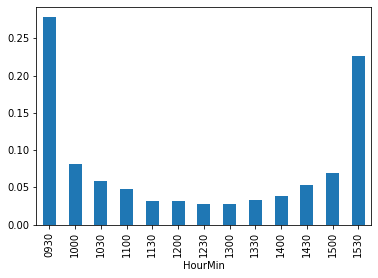

In [8]:
data1.groupby('HourMin')['HighBar'].mean().plot(kind='bar');

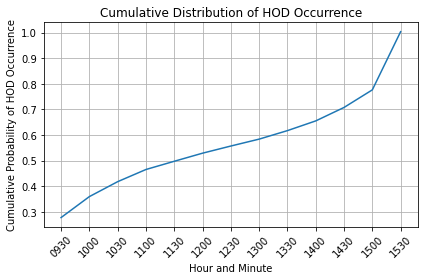

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

hod_prob = data1.groupby('HourMin')['HighBar'].mean()

hod_prob_sorted = hod_prob.sort_index()

cumulative_prob = hod_prob_sorted.cumsum()

# Plot the cumulative distribution curve
plt.plot(cumulative_prob.index, cumulative_prob.values)
plt.xlabel('Hour and Minute')
plt.ylabel('Cumulative Probability of HOD Occurrence')
plt.title('Cumulative Distribution of HOD Occurrence')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

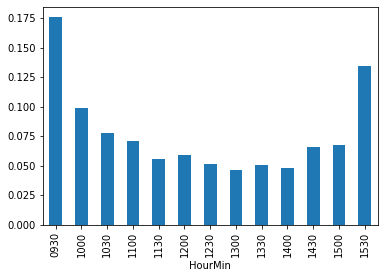

In [10]:
data1.groupby('HourMin')['LowBar'].mean().plot(kind='bar');

C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\1950565345.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(hod_prob.index, rotation=45)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\1950565345.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(lod_prob.index, rotation=45)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\1950565345.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(cumulative_hod.index, rotation=45)
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\1950565345.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(cumulative_lod.index, rotation=45)


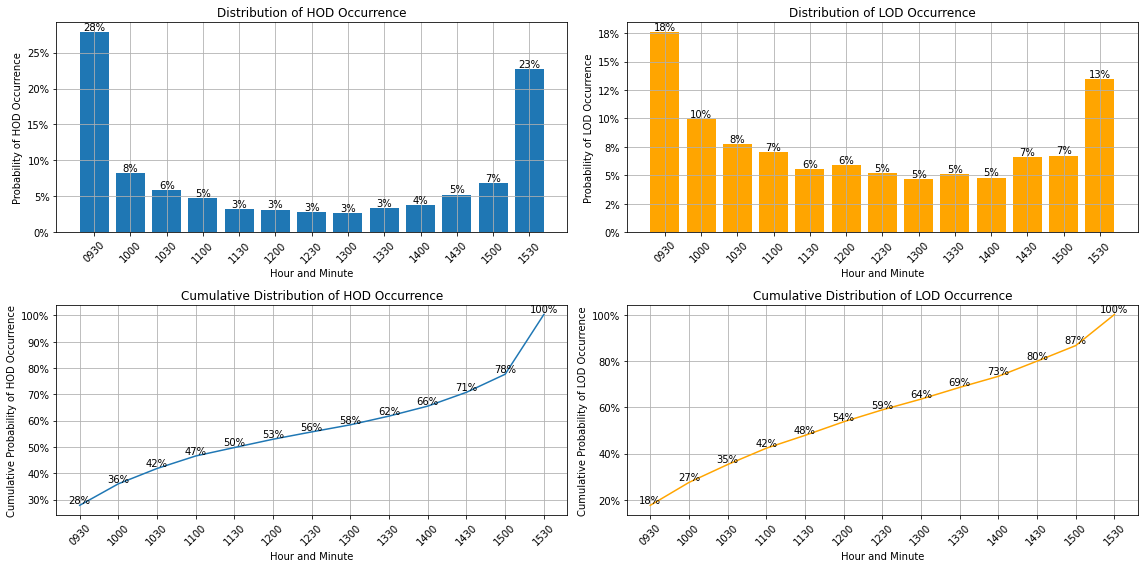

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'data1' with the 'HourMin', 'HighBar', and 'LowBar' columns

# Calculate the probability of High of Day (HOD) occurrence for each 'HourMin'
hod_prob = data1.groupby('HourMin')['HighBar'].mean()

# Calculate the probability of Low of Day (LOD) occurrence for each 'HourMin'
lod_prob = data1.groupby('HourMin')['LowBar'].mean()

# Sort the probabilities based on 'HourMin'
hod_prob_sorted = hod_prob.sort_index()
lod_prob_sorted = lod_prob.sort_index()

# Calculate the cumulative distributions
cumulative_hod = hod_prob_sorted.cumsum()
cumulative_lod = lod_prob_sorted.cumsum()

# Create a 2x4 grid of subplots with shared Y-axis
fig, axs = plt.subplots(2, 2, figsize=(16, 8),)

# Plot bar plot distributions of HOD and LOD
axs[0, 0].bar(hod_prob.index, hod_prob.values)
axs[0, 0].set_xlabel('Hour and Minute')
axs[0, 0].set_ylabel('Probability of HOD Occurrence')
axs[0, 0].set_title('Distribution of HOD Occurrence')
axs[0, 0].set_xticklabels(hod_prob.index, rotation=45)
axs[0, 0].grid()

# Format labels as percentages
axs[0, 0].yaxis.set_major_formatter('{:.0%}'.format)

# Add data labels to the graph
for x, y in zip(hod_prob.index, hod_prob.values):
    axs[0, 0].text(x, y, f'{y:.0%}', ha='center', va='bottom')

axs[0, 1].bar(lod_prob.index, lod_prob.values, color='orange')
axs[0, 1].set_xlabel('Hour and Minute')
axs[0, 1].set_ylabel('Probability of LOD Occurrence')
axs[0, 1].set_title('Distribution of LOD Occurrence')
axs[0, 1].set_xticklabels(lod_prob.index, rotation=45)
axs[0, 1].grid()

# Format labels as percentages
axs[0, 1].yaxis.set_major_formatter('{:.0%}'.format)

# Add data labels to the graph
for x, y in zip(lod_prob.index, lod_prob.values):
    axs[0, 1].text(x, y, f'{y:.0%}', ha='center', va='bottom')

# Plot cumulative distributions of HOD and LOD
axs[1, 0].plot(cumulative_hod.index, cumulative_hod.values)
axs[1, 0].set_xlabel('Hour and Minute')
axs[1, 0].set_ylabel('Cumulative Probability of HOD Occurrence')
axs[1, 0].set_title('Cumulative Distribution of HOD Occurrence')
axs[1, 0].set_xticklabels(cumulative_hod.index, rotation=45)
axs[1, 0].grid()

# Format labels as percentages
axs[1, 0].yaxis.set_major_formatter('{:.0%}'.format)

# Add data labels to the graph
for x, y in zip(cumulative_hod.index, cumulative_hod.values):
    axs[1, 0].text(x, y, f'{y:.0%}', ha='center', va='bottom')

axs[1, 1].plot(cumulative_lod.index, cumulative_lod.values, color='orange')
axs[1, 1].set_xlabel('Hour and Minute')
axs[1, 1].set_ylabel('Cumulative Probability of LOD Occurrence')
axs[1, 1].set_title('Cumulative Distribution of LOD Occurrence')
axs[1, 1].set_xticklabels(cumulative_lod.index, rotation=45)
axs[1, 1].grid()

# Format labels as percentages
axs[1, 1].yaxis.set_major_formatter('{:.0%}'.format)

# Add data labels to the graph
for x, y in zip(cumulative_lod.index, cumulative_lod.values):
    axs[1, 1].text(x, y, f'{y:.0%}', ha='center', va='bottom')

# # Remove unused subplots
# fig.delaxes(axs[1, 2])
# fig.delaxes(axs[1, 3])

plt.tight_layout()
plt.show()


In [12]:
data1.columns

Index(['Open', 'High', 'Low', 'Close', 'Date', 'HourMin', 'CurrentGap',
       'RowNumber', 'HighBar', 'LowBar'],
      dtype='object')

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'data1' with the 'HourMin', 'HighBar', and 'LowBar' columns

# List of values to filter and plot
data1['CurrentGapCat'] = pd.qcut(data1['CurrentGap'], 4)


C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_24704\2610222875.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['CurrentGapCat'] = pd.qcut(data1['CurrentGap'], 4)


In [20]:
data1

Open     High      Low    Close       Date HourMin  CurrentGap  \
0      1492.19  1492.91  1492.19  1492.87 2007-04-27    1200         NaN   
1      1492.54  1494.46  1492.30  1493.32 2007-04-27    1230         NaN   
2      1493.30  1494.45  1493.07  1494.41 2007-04-27    1300         NaN   
3      1494.60  1496.55  1494.31  1495.04 2007-04-27    1330         NaN   
4      1495.01  1496.97  1494.65  1495.85 2007-04-27    1400         NaN   
...        ...      ...      ...      ...        ...     ...         ...   
57168  4565.23  4567.31  4562.06  4564.47 2023-07-19    1330   -0.002484   
57169  4564.45  4565.74  4557.48  4560.63 2023-07-19    1400   -0.002484   
57170  4560.61  4568.09  4560.61  4567.86 2023-07-19    1430   -0.002484   
57171  4567.82  4574.66  4567.61  4572.09 2023-07-19    1500   -0.002484   
57172  4572.04  4572.04  4565.59  4565.65 2023-07-19    1530   -0.002484   

       RowNumber  HighBar  LowBar        CurrentGapCat  
0              1    False    True                  NaN  
1              2    False   False                  NaN  
2              3    False   False                  NaN  
3              4    False   False                  NaN  
4              5    False   False                  NaN  
...          ...      ...     ...                  ...  
57168          9    False   False  (-0.0757, -0.00219]  
57169         10    False    True  (-0.0757, -0.00219]  
57170         11    False   False  (-0.0757, -0.00219]  
57171         12    False   False  (-0.0757, -0.00219]  
57172         13    False   False  (-0.0757, -0.00219]  

[52956 rows x 11 columns]

In [19]:
len(data1)

52956

In [18]:
data1.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Date                 0
HourMin              0
CurrentGap       36490
RowNumber            0
HighBar              0
LowBar               0
CurrentGapCat    36490
dtype: int64

In [17]:
data1['CurrentGapCat'].unique()

[NaN, (0.000478, 0.00294], (0.00294, 0.0478], (-0.00219, 0.000478], (-0.0757, -0.00219]]
Categories (4, interval[float64, right]): [(-0.0757, -0.00219] < (-0.00219, 0.000478] < (0.000478, 0.00294] < (0.00294, 0.0478]]

In [ ]:

# Function to convert a float to a percentage string with desired precision
def float_to_percent(value, precision=2):
    return "{:.{precision}%}".format(value, precision=precision)

# Loop through the categories and convert the float intervals to percentage format
formatted_categories = []
for category in data1['CurrentGapCat']:
    # Get the lower and upper bounds of the interval and convert them to percentage strings
    lower_bound = float_to_percent(category.left, precision=2)
    upper_bound = float_to_percent(category.right, precision=2)
    formatted_categories.append((lower_bound, upper_bound))

print(formatted_categories)
data1['Labels'] = formatted_categories

tuples = sorted(list(set([s for s in zip(data1['CurrentGapCat'], data1['Labels'])])))

# Create a 1x2 grid of subplots with shared Y-axis
fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Loop through the specified values and plot the cumulative distributions
for t in tuples:
    # Filter the DataFrame based on the specified value
    gap = t[0]
    lbl = t[1]
    df_use = data1.loc[data1['CurrentGapCat'] == gap]  # Replace 'column_to_filter' with the appropriate column name
    
    # Calculate the probability of High of Day (HOD) occurrence for each 'HourMin'
    hod_prob = df_use.groupby('HourMin')['HighBar'].mean()
    
    # Calculate the probability of Low of Day (LOD) occurrence for each 'HourMin'
    lod_prob = df_use.groupby('HourMin')['LowBar'].mean()

    # Sort the probabilities based on 'HourMin'
    hod_prob_sorted = hod_prob.sort_index()
    lod_prob_sorted = lod_prob.sort_index()

    # Calculate the cumulative distributions
    cumulative_hod = hod_prob_sorted.cumsum()
    cumulative_lod = lod_prob_sorted.cumsum()

    # Plot cumulative distributions of HOD and LOD and assign them to the legend
    axs[0].plot(cumulative_hod.index, cumulative_hod.values, label=lbl)
    axs[1].plot(cumulative_lod.index, cumulative_lod.values, label=lbl)

# Set labels and title for the left plot (HOD)
axs[0].set_xlabel('Hour and Minute')
axs[0].set_ylabel('Cumulative Probability of HOD Occurrence')
axs[0].set_title('Cumulative Distribution of HOD Occurrence')
axs[0].set_xticklabels(cumulative_hod.index, rotation=45)
axs[0].grid()

# Format labels as percentages
axs[0].yaxis.set_major_formatter('{:.0%}'.format)

# Set labels and title for the right plot (LOD)
axs[1].set_xlabel('Hour and Minute')
axs[1].set_ylabel('Cumulative Probability of LOD Occurrence')
axs[1].set_title('Cumulative Distribution of LOD Occurrence')
axs[1].set_xticklabels(cumulative_lod.index, rotation=45)
axs[1].grid()

# Format labels as percentages
axs[1].yaxis.set_major_formatter('{:.0%}'.format)

# Add legend to the plots
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
data1.query('HourMin == "0930" & HighBar == True')

In [ ]:
tuples